In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
%matplotlib inline
sns.set()
#print(os.listdir("../input"))
# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0

In [ ]:
target_var = ['Target_Remaining_Useful_Life']
x_names=['UnitNumber','Cycle']
operational_settings=["Op_Setting_"+str(i) for i in range(1,4)]
sensor_measurements=['Sensor_'+str(i) for i in range(1,22)]
column_names=x_names+operational_settings+sensor_measurements
print(column_names)

['UnitNumber', 'Cycle', 'Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3', 'Sensor_1', 'Sensor_2', 'Sensor_3', 'Sensor_4', 'Sensor_5', 'Sensor_6', 'Sensor_7', 'Sensor_8', 'Sensor_9', 'Sensor_10', 'Sensor_11', 'Sensor_12', 'Sensor_13', 'Sensor_14', 'Sensor_15', 'Sensor_16', 'Sensor_17', 'Sensor_18', 'Sensor_19', 'Sensor_20', 'Sensor_21']


In [ ]:
from google.colab import files
uploaded=files.upload()

Saving train_FD001.txt to train_FD001 (1).txt


In [ ]:
for fn in uploaded.keys():
  print('user uploaded "{name}" with len{length} bytes'.format(name=fn,length=len(uploaded[fn])))

user uploaded "train_FD001.txt" with len3515356 bytes


In [ ]:
uploaded

{'train_FD001.txt': b'1 1 -0.0007 -0.0004 100.0 518.67 641.82 1589.70 1400.60 14.62 21.61 554.36 2388.06 9046.19 1.30 47.47 521.66 2388.02 8138.62 8.4195 0.03 392 2388 100.00 39.06 23.4190  \n1 2 0.0019 -0.0003 100.0 518.67 642.15 1591.82 1403.14 14.62 21.61 553.75 2388.04 9044.07 1.30 47.49 522.28 2388.07 8131.49 8.4318 0.03 392 2388 100.00 39.00 23.4236  \n1 3 -0.0043 0.0003 100.0 518.67 642.35 1587.99 1404.20 14.62 21.61 554.26 2388.08 9052.94 1.30 47.27 522.42 2388.03 8133.23 8.4178 0.03 390 2388 100.00 38.95 23.3442  \n1 4 0.0007 0.0000 100.0 518.67 642.35 1582.79 1401.87 14.62 21.61 554.45 2388.11 9049.48 1.30 47.13 522.86 2388.08 8133.83 8.3682 0.03 392 2388 100.00 38.88 23.3739  \n1 5 -0.0019 -0.0002 100.0 518.67 642.37 1582.85 1406.22 14.62 21.61 554.00 2388.06 9055.15 1.30 47.28 522.19 2388.04 8133.80 8.4294 0.03 393 2388 100.00 38.90 23.4044  \n1 6 -0.0043 -0.0001 100.0 518.67 642.10 1584.47 1398.37 14.62 21.61 554.67 2388.02 9049.68 1.30 47.16 521.68 2388.03 8132.85 8.4108 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
test_P='/content/drive/MyDrive/test_FD001.txt'
train_P='/content/drive/MyDrive/train_FD001.txt'

In [ ]:
test=pd.read_csv(test_P,sep=" ", header=None)
train=pd.read_csv(train_P,sep=" ", header=None)
train=train.head(150)
test=test.head(150)
print(train.shape)
print(test.shape)
# drop pesky NULL columns
train.drop(train.columns[[26, 27]], axis=1, inplace=True)
test.drop(test.columns[[26, 27]], axis=1, inplace=True)
# name columns
train.columns = column_names
test.columns = column_names

(150, 28)
(150, 28)


In [ ]:
is_long=train.UnitNumber<=5
is_long.head()
#train_data=train[is_long]

0    True
1    True
2    True
3    True
4    True
Name: UnitNumber, dtype: bool

In [ ]:
train_data=train[is_long]
max_cycle=pd.DataFrame(train_data.groupby('UnitNumber')['Cycle'].max()).reset_index()
max_cycle.columns= ['UnitNumber', 'MaxOfCycle']

In [ ]:
train_merged = train_data.merge(max_cycle, left_on='UnitNumber', right_on='UnitNumber', how='inner')
# calculate RUL for each row
Target_Remaining_Useful_Life = train_merged["MaxOfCycle"] - train_merged["Cycle"]
train_with_target = train_merged["Target_Remaining_Useful_Life"] = Target_Remaining_Useful_Life
# remove unnecessary column
train_with_target = train_merged.drop("MaxOfCycle", axis=1)
train_with_target.shape
train_with_target.head()

UnitNumber  Cycle  ...  Sensor_21  Target_Remaining_Useful_Life
0           1      1  ...    23.4190                           149
1           1      2  ...    23.4236                           148
2           1      3  ...    23.3442                           147
3           1      4  ...    23.3739                           146
4           1      5  ...    23.4044                           145

[5 rows x 27 columns]

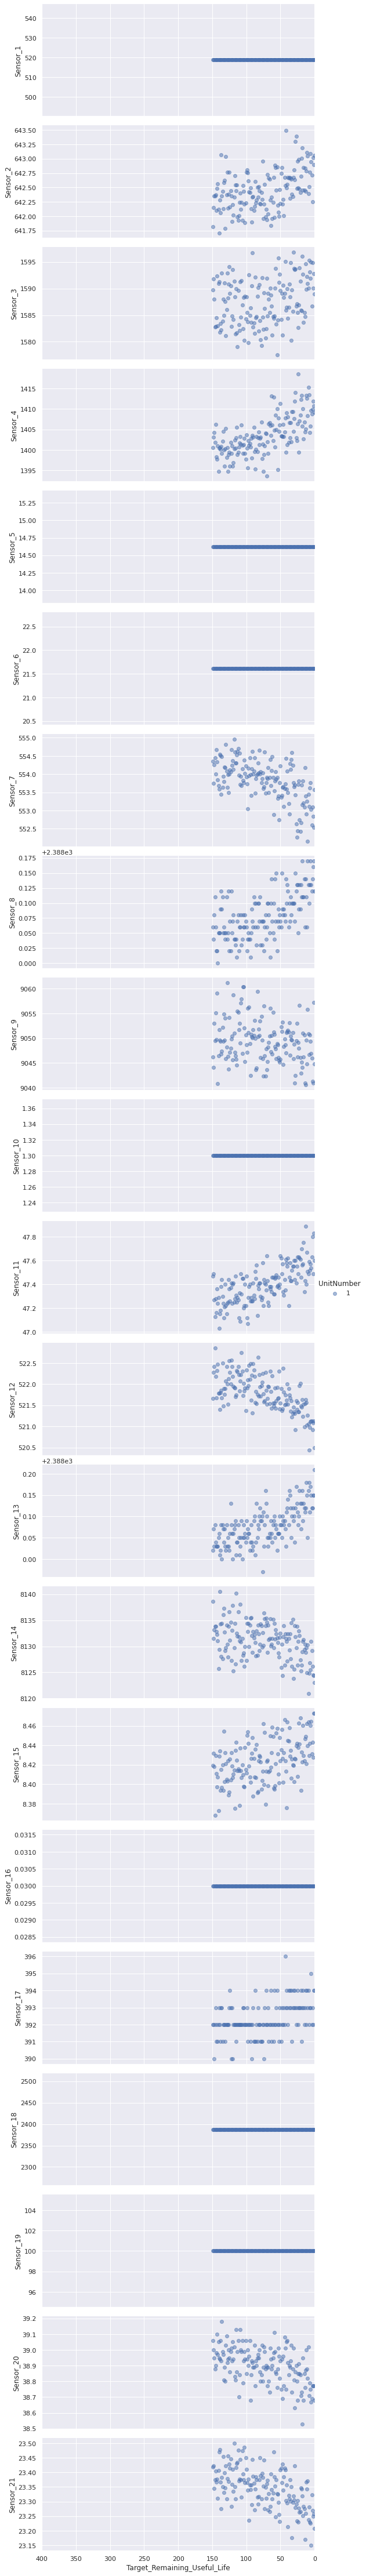

In [ ]:
explore = sns.PairGrid(data=train_with_target.query('UnitNumber < 15') ,
                 x_vars=target_var,
                 y_vars=sensor_measurements,
                 hue="UnitNumber", height=3, aspect=2.5)# hue will give u the variable as per color should be assigned
explore = explore.map(plt.scatter, alpha=0.5)# height*aspect gives the width
explore = explore.set(xlim=(400,0))
explore = explore.add_legend()


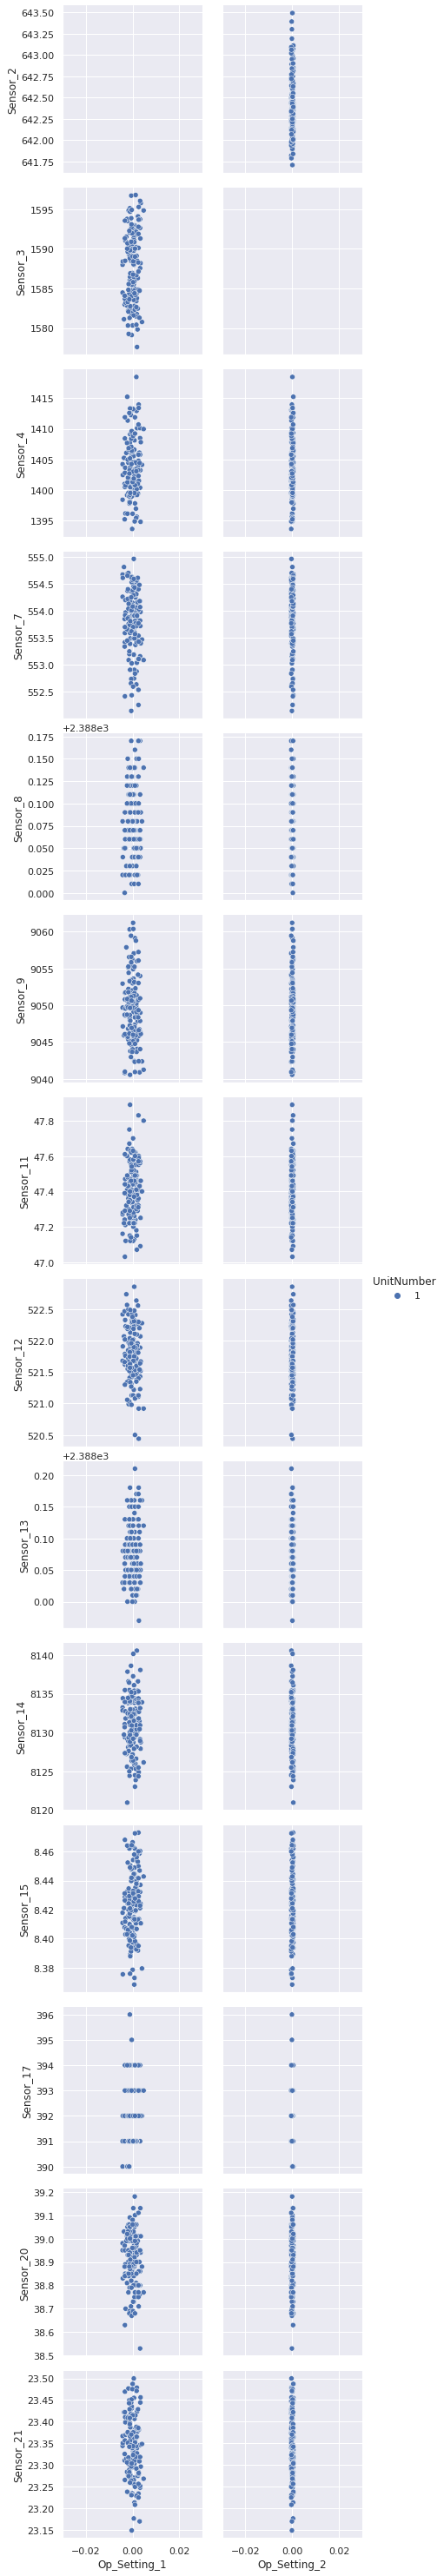

In [ ]:
# operational setting 3 is stable so lets visualize some of the most active sensors with operational setting 1 and 2
g = sns.pairplot(data=train_with_target.query('UnitNumber < 15'),
                 x_vars=["Op_Setting_1","Op_Setting_2"],
                 y_vars=["Sensor_2", "Sensor_3", "Sensor_4", "Sensor_7", "Sensor_8", "Sensor_9", "Sensor_11", "Sensor_12", "Sensor_13", "Sensor_14", "Sensor_15", "Sensor_17", "Sensor_20", "Sensor_21"],
                 hue="UnitNumber",height=3, aspect=1)
g = g.set(xlim=(-0.03,0.03))

In [ ]:
print(train_with_target.shape)
leakage_to_drop = ['UnitNumber', 'Cycle', 'Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3']  
train_no_leakage = train_with_target.drop(leakage_to_drop, axis = 1)
print(train_no_leakage.shape)
# set up features and target variable 
y = train_no_leakage['Target_Remaining_Useful_Life']
X = train_no_leakage.drop(['Target_Remaining_Useful_Life'], axis = 1)
X.head()

(150, 27)
(150, 22)


Sensor_1  Sensor_2  Sensor_3  ...  Sensor_19  Sensor_20  Sensor_21
0    518.67    641.82   1589.70  ...      100.0      39.06    23.4190
1    518.67    642.15   1591.82  ...      100.0      39.00    23.4236
2    518.67    642.35   1587.99  ...      100.0      38.95    23.3442
3    518.67    642.35   1582.79  ...      100.0      38.88    23.3739
4    518.67    642.37   1582.85  ...      100.0      38.90    23.4044

[5 rows x 21 columns]

In [ ]:
from sklearn import ensemble
rf = ensemble.RandomForestRegressor()
single_rf = ensemble.RandomForestRegressor(n_estimators = 200, max_depth = 15)
single_rf.fit(X, y)
y_pred = single_rf.predict(X)

print("complete")

complete


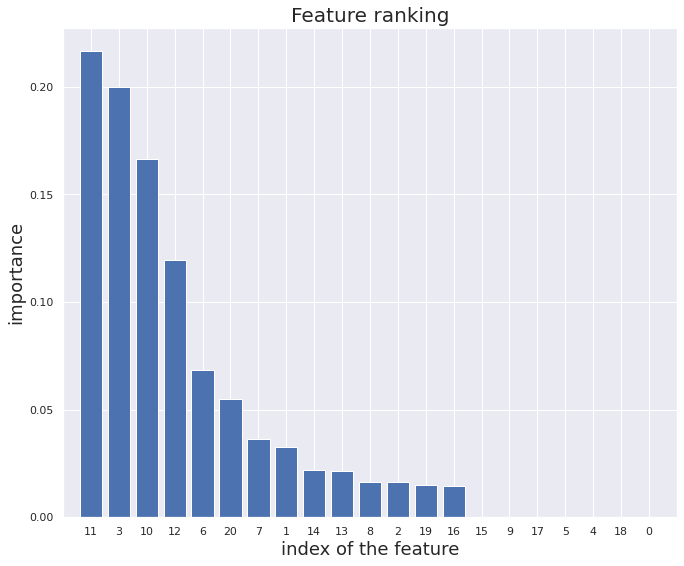

In [ ]:
import matplotlib.pyplot as plt
importances = single_rf.feature_importances_
#print(importances)
indices = np.argsort(importances)[::-1]
feature_names = X.columns    
f, ax = plt.subplots(figsize=(11, 9))
plt.title("Feature ranking", fontsize = 20)
plt.bar(range(X.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(X.shape[1]), indices) #feature_names, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.ylabel("importance", fontsize = 18)
plt.xlabel("index of the feature", fontsize = 18)
plt.show()
# list feature importance
#important_features = pd.Series(data=single_rf.feature_importances_,index=X.columns)
#important_features.sort_values(ascending=False,inplace=True)
#print(important_features.head(10))


In [ ]:
print(train_no_leakage.shape)
vars_drop=['Sensor_'+str(i) for i in [5,15,9,17,4,18]]
train_final=train_no_leakage.drop(vars_drop,axis=1)
print(train_final.shape)

(150, 22)
(150, 16)


In [ ]:
from sklearn import preprocessing
categorical = train_final.select_dtypes(include=['object'])
numeric = train_final.select_dtypes(exclude=['object'])
print(categorical.columns.values)
print(numeric.columns.values)
# create dummy variables (if any categorical fields)
for name, values in categorical.items():
    print(name)
    dummies = pd.get_dummies(values.str.strip(), prefix = name, dummy_na=True)
    numeric = pd.concat([numeric, dummies], axis=1)
# imputation (if any NULL values)
for name in numeric:
    print(name)
    if pd.isnull(numeric[name]).sum() > 0:
        numeric["%s_mi" % (name)] = pd.isnull(numeric[name])
        median = numeric[name].median()
        numeric[name] = numeric[name].apply(lambda x: median if pd.isnull(x) else x)
y = numeric['Target_Remaining_Useful_Life']
X = numeric.drop(['Target_Remaining_Useful_Life'], axis = 1)


[]
['Sensor_1' 'Sensor_2' 'Sensor_3' 'Sensor_6' 'Sensor_7' 'Sensor_8'
 'Sensor_10' 'Sensor_11' 'Sensor_12' 'Sensor_13' 'Sensor_14' 'Sensor_16'
 'Sensor_19' 'Sensor_20' 'Sensor_21' 'Target_Remaining_Useful_Life']
Sensor_1
Sensor_2
Sensor_3
Sensor_6
Sensor_7
Sensor_8
Sensor_10
Sensor_11
Sensor_12
Sensor_13
Sensor_14
Sensor_16
Sensor_19
Sensor_20
Sensor_21
Target_Remaining_Useful_Life


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
# choose the model
from sklearn.ensemble import RandomForestRegressor
rf = ensemble.RandomForestRegressor()
# set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)
# pipeline standardization and model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', rf) ])
# tune the model
my_min_samples_leaf = [2, 10, 25, 50, 100]
my_max_depth = [7, 8, 9, 10, 11, 12]
# run the model using gridsearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_rf = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, model__max_depth = my_max_depth)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_rf.fit(X_train, y_train)
# show the best model estimators
print(optimized_rf.best_estimator_)
# evaluate metrics on holdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = optimized_rf.predict(X_test)
print("Random Forest Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("Random Forest Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("Random Forest r-squared: ", r2_score(y_test, y_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.5s


Pipeline(memory=None,
         steps=[('standardize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=10,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=2, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)
Random Forest Mean Squared Error:  457.31721932

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   17.9s finished


In [ ]:
import pickle
with open('optimized_rf','wb')as f:
    pickle.dump(optimized_rf,f)
with open('optimized_rf','rb')as f:
    mp=pickle.load(f)


In [ ]:
test.head()

UnitNumber  Cycle  Op_Setting_1  ...  Sensor_19  Sensor_20  Sensor_21
0           1      1        0.0023  ...      100.0      38.86    23.3735
1           1      2       -0.0027  ...      100.0      39.02    23.3916
2           1      3        0.0003  ...      100.0      39.08    23.4166
3           1      4        0.0042  ...      100.0      39.00    23.3737
4           1      5        0.0014  ...      100.0      38.99    23.4130

[5 rows x 26 columns]

In [ ]:
is_long=train.UnitNumber<=2
is_long.head()

0    True
1    True
2    True
3    True
4    True
Name: UnitNumber, dtype: bool

In [ ]:
test_data=test[is_long]
max_cycle=pd.DataFrame(test_data.groupby('UnitNumber')['Cycle'].max()).reset_index()
max_cycle.columns= ['UnitNumber', 'MaxOfCycle']

In [ ]:
test_merged = test_data.merge(max_cycle, left_on='UnitNumber', right_on='UnitNumber', how='inner')
# calculate RUL for each row
Target_Remaining_Useful_Life = test_merged["MaxOfCycle"] - test_merged["Cycle"]
test_with_target = test_merged["Target_Remaining_Useful_Life"] = Target_Remaining_Useful_Life
# remove unnecessary column
test_with_target = test_merged.drop("MaxOfCycle", axis=1)
test_with_target.shape
test_with_target.head()

UnitNumber  Cycle  ...  Sensor_21  Target_Remaining_Useful_Life
0           1      1  ...    23.3735                            30
1           1      2  ...    23.3916                            29
2           1      3  ...    23.4166                            28
3           1      4  ...    23.3737                            27
4           1      5  ...    23.4130                            26

[5 rows x 27 columns]

In [ ]:
print(test_with_target.shape)
leakage_to_drop = ['UnitNumber', 'Cycle', 'Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3']  
test_no_leakage = test_with_target.drop(leakage_to_drop, axis = 1)
print(test_no_leakage.shape)
# set up features and target variable 
y = test_no_leakage['Target_Remaining_Useful_Life']
X = test_no_leakage.drop(['Target_Remaining_Useful_Life'], axis = 1)
X.head()

(150, 27)
(150, 22)


Sensor_1  Sensor_2  Sensor_3  ...  Sensor_19  Sensor_20  Sensor_21
0    518.67    643.02   1585.29  ...      100.0      38.86    23.3735
1    518.67    641.71   1588.45  ...      100.0      39.02    23.3916
2    518.67    642.46   1586.94  ...      100.0      39.08    23.4166
3    518.67    642.44   1584.12  ...      100.0      39.00    23.3737
4    518.67    642.51   1587.19  ...      100.0      38.99    23.4130

[5 rows x 21 columns]

In [ ]:
print(test_no_leakage.shape)
vars_drop=['Sensor_'+str(i) for i in [5,15,9,17,4,18]]
test_final=test_no_leakage.drop(vars_drop,axis=1)
print(test_final.shape)

(150, 22)
(150, 16)


In [ ]:
y_actual = test_final['Target_Remaining_Useful_Life']
X_test = test_final.drop(['Target_Remaining_Useful_Life'], axis = 1)

In [ ]:
y_pred=mp.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# after dealing with test data
print("Random Forest Mean Squared Error: ", mean_squared_error(y_actual, y_pred))
print("Random Forest Mean Absolute Error: ", mean_absolute_error(y_actual, y_pred))
print("Random Forest r-squared: ", r2_score(y_actual, y_pred))

Random Forest Mean Squared Error:  2280.788691056382
Random Forest Mean Absolute Error:  35.112596285762166
Random Forest r-squared:  -5.883701322872731


In [ ]:
y_pred

array([114.2697619 , 106.80333225, 109.518     ,  95.82483369,
       121.5596627 , 116.51205556, 101.88888641, 113.52904365,
       108.63491667, 119.74706895, 120.75985317, 114.33073846,
       119.69188889, 119.93469481,  77.96326984,  85.29097619,
       121.8477619 , 108.02128571, 124.16900794, 104.68251709,
        95.67401984,  88.07060714, 106.29496465,  60.56030952,
       108.47038095, 106.05200397, 114.38277381, 104.78642749,
       107.12201082,  84.96146032, 110.10697222,  37.919     ,
        92.0402381 ,  34.65228571,  69.87481746,  44.76457143,
        69.40586508,  30.47759524,  48.03166667,  44.94033333,
        25.97639286,  37.08166667,  34.52747619,  47.38240476,
        54.20021429,  45.83240476,  52.70358333,  56.53520635,
        61.20417063,  90.37658333,  22.90007143,  46.58021429,
        70.35292857,  86.5817381 ,  54.63463889,  45.50346032,
        23.58631746,  23.47380952,  47.55728571,  39.239     ,
        60.28428571,  21.84742857,  24.01897619,  45.99

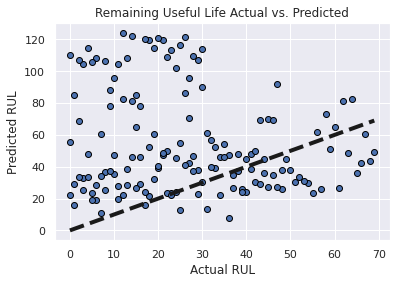

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_actual, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'k--', lw=4)
ax.set_xlabel('Actual RUL')
ax.set_ylabel('Predicted RUL')
ax.set_title('Remaining Useful Life Actual vs. Predicted')
plt.show()